# Generating Lego Bricks with Diffusion
Dataset used: lego-brick-images from joosthazelzet on Kaggle

In [1]:
import torch
from torch import Tensor
from torch.utils.data import Dataset, random_split
from torch import linspace, rand_like
from torch import inference_mode
from torch import optim
from torch.nn import functional as F

import torchvision.transforms as transforms

from matplotlib import pyplot as plt

import numpy as np
import os
import kagglehub
import diffusers

## Data
Download and create the Dataset

In [2]:
path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")

print("Path to dataset files:", path)

Path to dataset files: /home/pedro/.cache/kagglehub/datasets/joosthazelzet/lego-brick-images/versions/4


In [3]:

class lego(Dataset):
    
    def __init__(self, images:list[str], source_dir:str, transforms:transforms =None, classes: dict=None):
        np.random.shuffle(images)
        self.classes = classes if classes is not None else {}
        self.num_classes = 0 if self.classes is None else len(self.classes)
        self.dataset_x = []
        self.dataset_y = []
        self.transforms = transforms
        
        for name in images:
            temp = name.split()
            self.dataset_x.append(f"{source_dir}{name}")
            image_class = "_".join(temp[1:-1])
                        
            if (image_class not in self.classes):
                self.classes[image_class] = self.num_classes
                self.num_classes += 1
            self.dataset_y.append(self.classes[image_class])
        
    def __getitem__(self, idx):
        image = plt.imread(self.dataset_x[idx])
        if self.transforms is not None:
            image = self.transforms(image)
        return image, self.dataset_y[idx]

    def __len__(self):
        return len(self.dataset_x)

In [6]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize([64,64])

])

In [7]:
source_dir=path + "/dataset/"
images = os.listdir(source_dir)

Lego_dataset = lego(images, source_dir, trans)

In [8]:
train, val = random_split(Lego_dataset, [0.8,0.2])
len(train)

32000

### A little fnct to show easily images

In [9]:
from torch import cat
def show_images(images_tensor: Tensor):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap="gray");
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap="gray");

In [10]:
from torch import concat
def show_images_list(images_list:list[Tensor]) -> None:

    images_tensor = concat(images_list,dim=0)

    # return images_tensor
    show_images(images_tensor.unsqueeze(1))

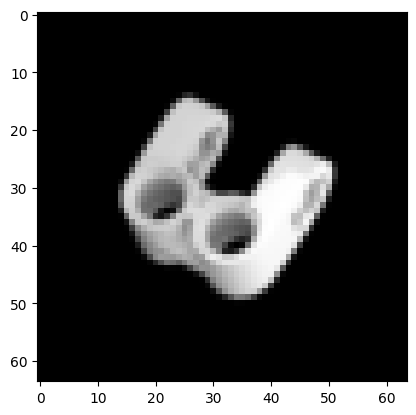

In [11]:
show_images(train[23650][0])

## Preparing images to the net

In [12]:
#   Create the Dataloader
from torch.utils.data import DataLoader
batch_size = 64

train_dataloader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True
)


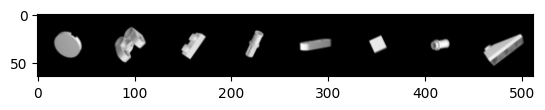

In [13]:
show_images(next(iter(train_dataloader))[0][:8])

## Add Noise

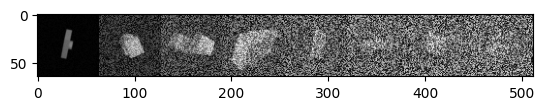

In [22]:
scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.005
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
batch = next(iter(train_dataloader))
x = batch[0][:8]
noise = rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images(noised_x)

## U-Net

In [23]:
from diffusers import UNet2DModel

image_size = 128
model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    sample_size=image_size,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),
    out_channels=1

).cuda()

# Pass a batch of data through to make sure it works. The dimensions of tensors must be the same
with inference_mode():
    out = model(noised_x.cuda(), timestep=timesteps.cuda()).sample

print(noised_x.shape)
print(out.shape)

torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])


## Training Loops

In [24]:
n_epochs = 5
lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr = lr)
loss_fn = F.mse_loss
losses = []

In [25]:
from torch import nn
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, scheduler: diffusers.schedulers, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = 0
    losses_list = []

    for nlote,x in enumerate(loader):
        x = x[0].cuda()

        ## Noise
        # Make noise
        noise = torch.randn_like(x).cuda()

        # Create random timesteps to the training
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (x.shape[0],)
        ).long().cuda()

        # Add Noise to images
        noisy_x = scheduler.add_noise(x,noise,timesteps)

        ## Forward Pass
        noise_pred = model(noisy_x, timesteps, return_dict = False)[0]
        
        
        ## Back-propagation
        # Calc of loss
        loss = loss_fn(noise_pred, noise)    #Calculo de loss
        
        # Save Loss
        losses_list.append(loss.item())

        # Steps of training
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas características para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print()

    train_losses /= nlotes
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {train_losses:>8f}")

    return losses_list

In [26]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, scheduler: diffusers.schedulers, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Cancelo el calculo del gradiente
        for x in loader:
            
            x = x[0].cuda()

            ## Noise
            noise = torch.randn_like(x)

            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (x.shape[0],)
            ).long().cuda()

            noisy_x = scheduler.add_noise(x, noise, timesteps)

            noise_pred = model(noisy_x, timesteps, return_dict=False)[0]       # Inferencia
            
            loss = loss_fn(noise_pred, noise)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\t\t Validación: {val_losses:>8f}")

    return losses_list


## The training

In [27]:
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    print(f"Iteración: {(epoch + 1)} / {n_epochs} -----------------------------")
    
    #Train
    train_loss  += train_loop(train_dataloader,model,scheduler,optimizer,loss_fn)
    
    #Validation
    val_output = val_loop(val_dataloader,model,scheduler,loss_fn)
    val_loss += val_output

print("Finalizado entrenamiento del modelo!")

Iteración: 1 / 5 -----------------------------
Nº de lote:	 0
Loss:			 1.0623217821121216

Nº de lote:	 10
Loss:			 0.3340970277786255

Nº de lote:	 20
Loss:			 0.15306442975997925

Nº de lote:	 30
Loss:			 0.08969065546989441

Nº de lote:	 40
Loss:			 0.06612756848335266

Nº de lote:	 50
Loss:			 0.0614611878991127

Nº de lote:	 60
Loss:			 0.051368288695812225

Nº de lote:	 70
Loss:			 0.048580337315797806

Nº de lote:	 80
Loss:			 0.04652209207415581

Nº de lote:	 90
Loss:			 0.03782489895820618

Nº de lote:	 100
Loss:			 0.05068765580654144

Nº de lote:	 110
Loss:			 0.03549863398075104

Nº de lote:	 120
Loss:			 0.031682614237070084

Nº de lote:	 130
Loss:			 0.028876420110464096

Nº de lote:	 140
Loss:			 0.027056915685534477

Nº de lote:	 150
Loss:			 0.032397352159023285

Nº de lote:	 160
Loss:			 0.028671670705080032

Nº de lote:	 170
Loss:			 0.022438552230596542

Nº de lote:	 180
Loss:			 0.021135814487934113

Nº de lote:	 190
Loss:			 0.021417170763015747

Nº de lote:	 200


In [28]:
torch.save(model.state_dict(),"Lego_first_train.pth")

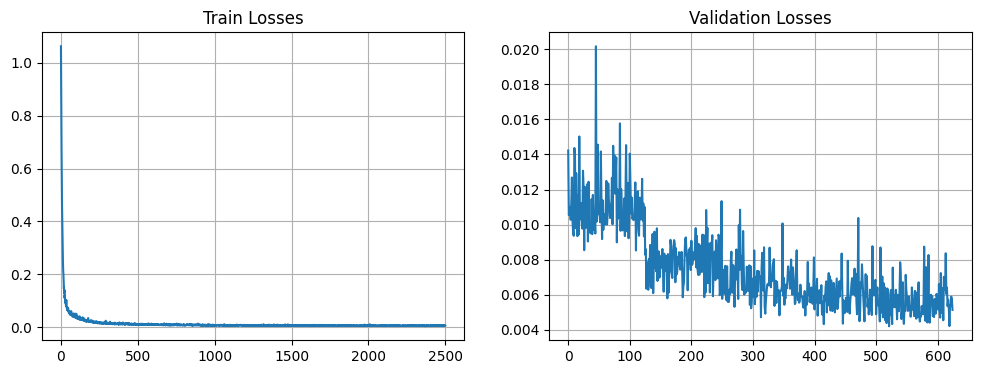

In [29]:
plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Train Losses")
plt.plot(range(len(train_loss)),train_loss);
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation Losses")
plt.plot(range(len(val_loss)),val_loss);
plt.grid()

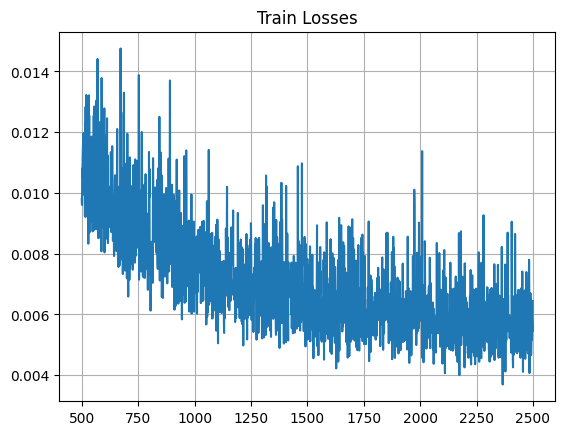

In [30]:
plt.title("Train Losses")
plt.plot(range(500,len(train_loss)),train_loss[500:]);
plt.grid()

## Generations of images

In [31]:
pipeline = diffusers.DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=8).images

  0%|          | 0/1000 [00:00<?, ?it/s]

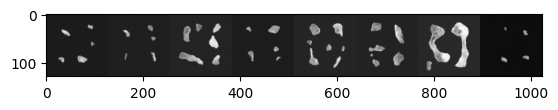

In [ ]:
ToTensor = transforms.ToTensor()
imgs_tensor = [ToTensor(img) for img in ims]
show_images_list(images_list=imgs_tensor)

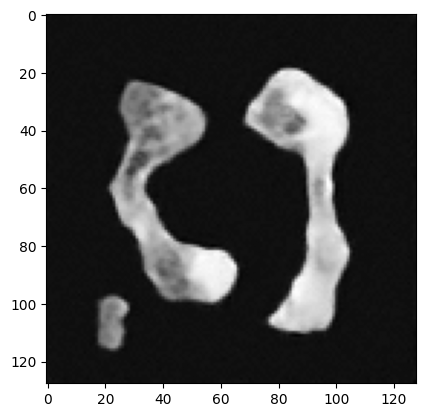

In [35]:
show_images(imgs_tensor[6])

El Modelo genera resultados, con imágenes en buena calidad, pero no representan correctamente piezas de lego, como era el objetivo principal.
El problema puede tener varios orígenes:

* Tamaño de las imágenes insuficiente 64x64
* Beta_end del planificador de ruido no ajustado correctamente. Esto puede generar que el ruido generado sea o insuficiente o demasiado.
* Overfitting: Puede haber ocurrido que existiesen demasiadas imágenes de cada tipo de pieza de lego. Eso ha podido producir que las imágenes generadas no reflejen la realidad.
* Puede ser que el dataset elegido no sea el más adecuado para la tarea de generar imágenes. existen gran número de imágenes de la mismas 50 piezas, en vez de existir una gran variedad de tipos de piezas.
     